In [60]:
import csv
import heapq

In [61]:
class Node:
    def __init__(self, name, g_cost, h_cost, parent=None):
        self.name = name
        self.g_cost = g_cost  # Cost from start to current node
        self.h_cost = h_cost  # Heuristic cost from current node to goal
        self.f_cost = g_cost + h_cost  # Total cost
        self.parent = parent

    def __lt__(self, other):
        return self.f_cost < other.f_cost

In [62]:
def load_nodes(filename):
    nodes = {}
    with open(filename, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            nodes[row['node_name']] = {
                'type': row['type'],
                'x': float(row['x']),
                'y': float(row['y'])
            }
    return nodes

In [63]:
def load_edges(filename):
    edges = {}
    with open(filename, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row['from_node'] not in edges:
                edges[row['from_node']] = []
            edges[row['from_node']].append((row['to_node'], int(row['cost']), row['mode'], int(row['time'])))
    return edges

In [64]:
def load_transfers(filename):
    transfers = {}
    with open(filename, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row['node_name'] not in transfers:
                transfers[row['node_name']] = []
            transfers[row['node_name']].append({
                'from_mode': row['from_mode'],
                'to_mode': row['to_mode'],
                'cost': int(row['transfer_cost']),
                'time': float(row['transfer_time'])
            })
    return transfers

In [65]:
def load_dynamic_factors(filename):
    factors = {}
    with open(filename, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            factors[(row['from_node'], row['to_node'])] = {
                'accident_risk': float(row['accident_risk']),
                'congestion_factor': float(row['congestion_factor']),
                'weather_delay': float(row['weather_delay']),
            }
    return factors

In [66]:
def adjust_costs_dynamic(node, to_node, base_cost, current_conditions):
    """
    Adjust the cost dynamically based on conditions like accidents, weather, etc.
    """
    factor = current_conditions.get((node, to_node), {})
    accident_risk = factor.get('accident_risk', 1)
    congestion_factor = factor.get('congestion_factor', 1)
    weather_delay = factor.get('weather_delay', 1)

    w1=0.4 #accident risk
    w2=0.5 #congestion factor
    w3=0.6 #weather delay
    
    adjusted_cost = base_cost * (1 + w1 * accident_risk + w2 * congestion_factor + w3 * weather_delay)

    return adjusted_cost

In [67]:
def manhattan_distance(node, goal_node):
    # Simplified Manhattan distance as heuristic
    return abs(node['x'] - goal_node['x']) + abs(node['y'] - goal_node['y'])


This code works but dont use the dynamic factor to calculate cost

In [68]:
def a_star_search_dynamic(start, goal, nodes, edges, transfers, time_window, dynamic_factors):
    # Initialize open and closed lists
    open_list = []
    closed_list = set()
    
    # Add the start node to the open list
    open_list.append((0, start))
    
    # Dictionary to store the cost of reaching each node
    g_costs = {start: 0}
    
    # Dictionary to store the path
    came_from = {}
    
    while open_list:
        # Get the node with the lowest cost
        current_cost, current_node = min(open_list, key=lambda x: x[0])
        open_list.remove((current_cost, current_node))
        
        # If the goal is reached, reconstruct the path
        if current_node == goal:
            path = []
            while current_node in came_from:
                path.append(current_node)
                current_node = came_from[current_node]
            path.append(start)
            return path[::-1]
        
        closed_list.add(current_node)
        
        # Check if the current node has neighbors in the edges dictionary
        if current_node not in edges:
            continue  # Skip if no neighbors
        
        for neighbor, base_cost, mode, travel_time in edges[current_node]:
            if neighbor in closed_list:
                continue
            
            # Calculate the cost to reach the neighbor
            tentative_g_cost = g_costs[current_node] + base_cost
            
            if neighbor not in g_costs or tentative_g_cost < g_costs[neighbor]:
                g_costs[neighbor] = tentative_g_cost
                total_cost = tentative_g_cost  # Add heuristic if needed
                open_list.append((total_cost, neighbor))
                came_from[neighbor] = current_node
    
    return None  # Return None if no path is found



Code to take care of adjusted factors also

In [69]:
def a_star_search_dynamic(start, goal, nodes, edges, transfers, time_window, current_conditions):
    open_list = []
    closed_list = set()
    
    start_node = Node(start, 0, manhattan_distance(nodes[start], nodes[goal]))
    heapq.heappush(open_list, start_node)
    
    while open_list:
        current_node = heapq.heappop(open_list)
        
        if current_node.name == goal:
            path = []
            while current_node:
                path.append(current_node.name)
                current_node = current_node.parent
            return path[::-1]
        
        closed_list.add(current_node.name)
        
        if current_node.name not in edges:
            continue
        
        for neighbor, base_cost, mode, travel_time in edges[current_node.name]:
            if neighbor in closed_list:
                continue
            
            adjusted_cost = adjust_costs_dynamic(current_node.name, neighbor, base_cost, current_conditions)
            g_cost = current_node.g_cost + adjusted_cost
            
            if g_cost > time_window:
                continue
            
            h_cost = manhattan_distance(nodes[neighbor], nodes[goal])
            neighbor_node = Node(neighbor, g_cost, h_cost, current_node)
            heapq.heappush(open_list, neighbor_node)
    
    return None

In [70]:
# Load data from CSV files
nodes = load_nodes('nodes.csv')

In [71]:
edges = load_edges('edges.csv')

In [72]:
transfers = load_transfers('transfer.csv')

In [73]:
dynamic_factors = load_dynamic_factors('dynamic_factors.csv')

##PLOTTING THE GRAPH

In [ ]:
!pip install networkx

In [ ]:
!pip install --user matplotlib

In [91]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

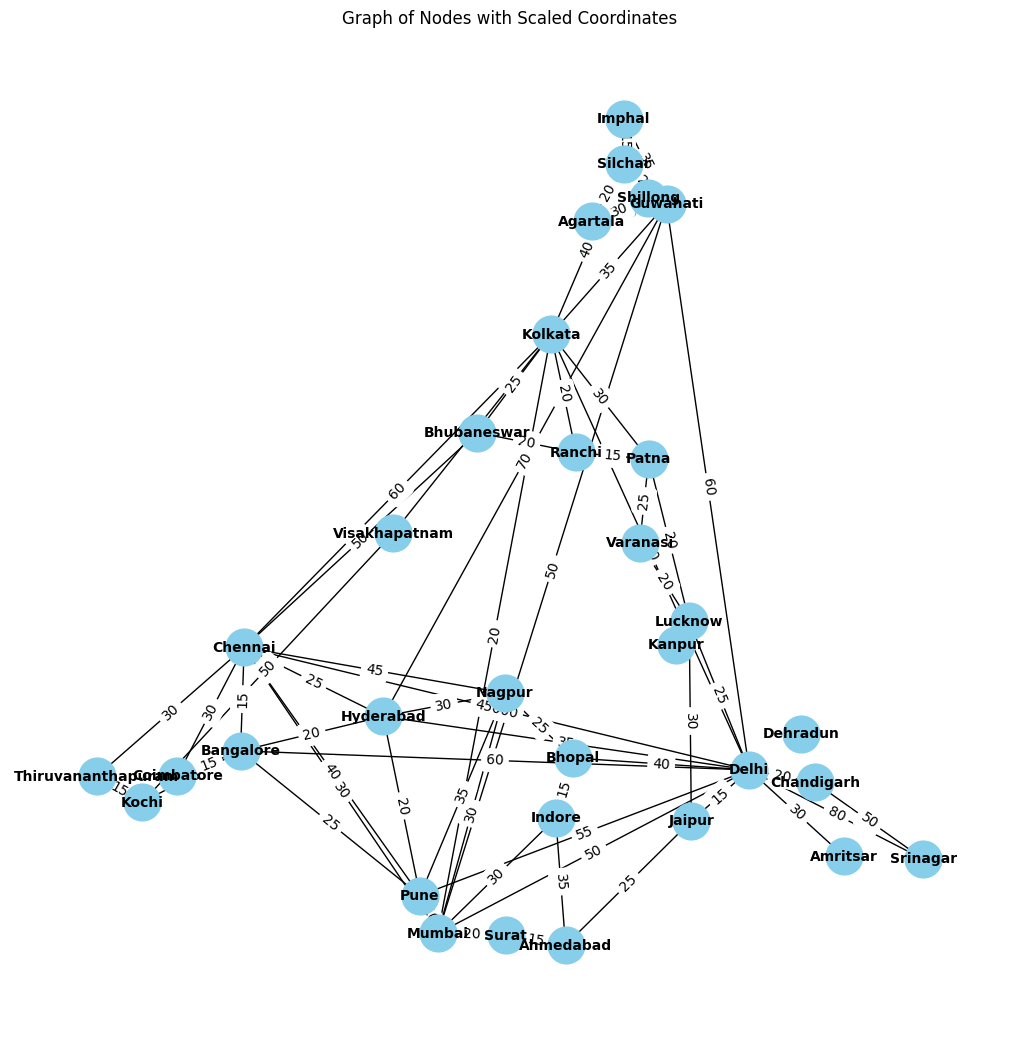

In [95]:


# Read the nodes data (replace with your CSV path)
nodes = pd.read_csv('nodes.csv')

# Normalize latitudes and longitudes to create feasible points for plotting
# Apply scaling factors to spread the points for better visualization

def scale_coordinates(df, scale_factor=100):
    # Normalize latitudes and longitudes
    min_lat, max_lat = df['x'].min(), df['x'].max()
    min_lon, max_lon = df['y'].min(), df['y'].max()

    df['scaled_x'] = ((df['x'] - min_lat) / (max_lat - min_lat)) * scale_factor
    df['scaled_y'] = ((df['y'] - min_lon) / (max_lon - min_lon)) * scale_factor
    return df

# Scale coordinates
scaled_nodes = scale_coordinates(nodes)

# Save to a new CSV file, retaining the original data and adding scaled coordinates
scaled_nodes.to_csv('scaled_nodes.csv', index=False)

# Read the edges data (replace with your CSV path)
edges = pd.read_csv('edges.csv')

# Create a graph using networkx
G = nx.Graph()

# Add nodes with positions (scaled coordinates)
for index, row in scaled_nodes.iterrows():
    G.add_node(row['node_name'], pos=(row['scaled_x'], row['scaled_y']))

# Add edges with time and cost (from the original CSV)
for index, row in edges.iterrows():
    G.add_edge(row['from_node'], row['to_node'], weight=row['cost'], time=row['time'])

# Get positions for drawing the graph
pos = nx.get_node_attributes(G, 'pos')

# Draw the graph
plt.figure(figsize=(10, 10))
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=10, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(row['from_node'], row['to_node']): row['cost'] for _, row in edges.iterrows()})
plt.title("Graph of Nodes with Scaled Coordinates")
plt.show()


##TAKING THE INPUT

In [ ]:
%pip install ipywidgets 

In [87]:
from IPython.display import display
import ipywidgets as widgets

# Load unique city names from file
with open('unique_city_names.txt', 'r') as file:
    unique_cities = [line.strip() for line in file]

# Create dropdown widgets for start and goal cities
start_dropdown = widgets.Dropdown(
    options=unique_cities,
    description='Start:',
    value='Delhi'
)

goal_dropdown = widgets.Dropdown(
    options=unique_cities,
    description='Goal:',
    value='Chennai'
)

# Create an integer slider for the time window
time_window_slider = widgets.IntSlider(
    value=100,
    min=1,
    max=1000,
    step=10,
    description='Time Window:'
)

# Display the widgets
display(start_dropdown, goal_dropdown, time_window_slider)

# Global variables to store the selected values
selected_start = start_dropdown.value
selected_goal = goal_dropdown.value
selected_time_window = time_window_slider.value

# Function to update the global variables when the widget value changes
def update_start(change):
    global selected_start
    selected_start = change['new']

def update_goal(change):
    global selected_goal
    selected_goal = change['new']

def update_time_window(change):
    global selected_time_window
    selected_time_window = change['new']

# Add observers to the widgets to update global variables dynamically
start_dropdown.observe(update_start, names='value')
goal_dropdown.observe(update_goal, names='value')
time_window_slider.observe(update_time_window, names='value')

# Now the values of selected_start, selected_goal, and selected_time_window
# will be globally accessible and updated dynamically when the widgets are changed.


Dropdown(description='Start:', index=16, options=('Visakhapatnam', 'Lucknow', 'Nagpur', 'Indore', 'Patna', 'Ja…

Dropdown(description='Goal:', index=20, options=('Visakhapatnam', 'Lucknow', 'Nagpur', 'Indore', 'Patna', 'Jai…

IntSlider(value=100, description='Time Window:', max=1000, min=1, step=10)

In [82]:
print(f"Start City: {selected_start}")
print(f"Goal City: {selected_goal}")
print(f"Time Window: {selected_time_window}")


Start City: Delhi
Goal City: Silchar
Time Window: 259678


In [84]:
# Run A* search with dynamic factors
optimal_path = a_star_search_dynamic(selected_start, selected_goal, nodes, edges, transfers, selected_time_window, dynamic_factors)
print("Optimal Path with Dynamic Factors:", optimal_path)

Optimal Path with Dynamic Factors: ['Visakhapatnam', 'Kolkata', 'Silchar']


##UTILITY CODE

In [77]:
#The following is a helper code the make all routes bidirectional


import pandas as pd

# Load the CSV data into a DataFrame
df = pd.read_csv("edges.csv")

# Create a new DataFrame with reversed routes
reversed_df = df.copy()
reversed_df.columns = ['to_node', 'from_node', 'mode', 'cost', 'time']

# Combine original and reversed dataframes
combined_df = pd.concat([df, reversed_df], ignore_index=True)

# Remove duplicate routes (if any)
combined_df = combined_df.drop_duplicates()

# Save the modified DataFrame to a new CSV file
combined_df.to_csv("edges.csv", index=False)